In [1]:
import numpy as np
import matplotlib.pyplot as plt
from inktime import rgbkm
from mpl_toolkits.mplot3d import Axes3D
from PIL import Image
import cv2

In [102]:
%matplotlib widget

img = cv2.imread('red_fuji3.jpg') # high res
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

### Canny edge detection

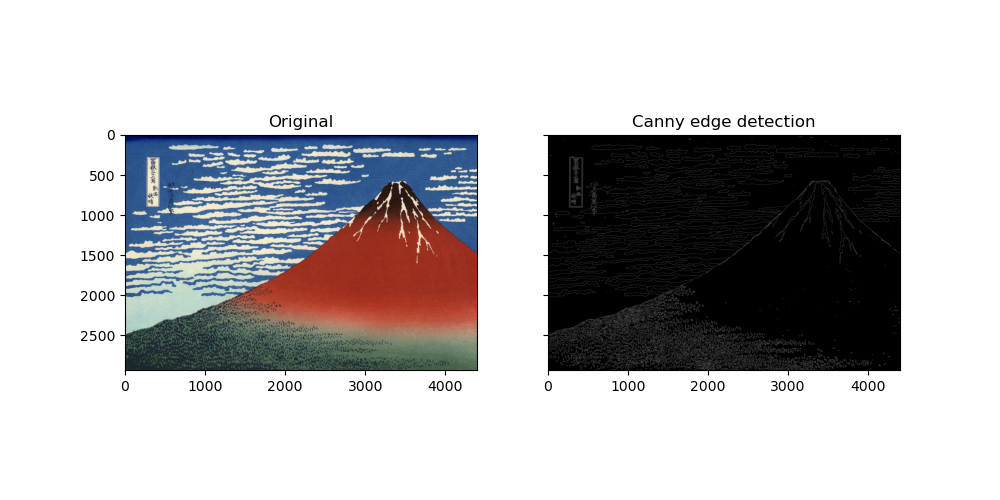

In [105]:
lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB).astype(np.float32)
blur = cv2.GaussianBlur(lab, (0, 0), 1.5).astype(np.uint8)

v = np.median(blur)
lower = 0.2 * v
upper = 0.7 * v

edges = cv2.Canny(blur, lower, upper, L2gradient=True) 

plt.close()
fig, ax = plt.subplots(1,2, figsize = (10,5), sharex = True, sharey = True)
ax[0].set_title("Original")
ax[0].imshow(img, cmap = 'gray')
ax[1].set_title("Canny edge detection")
ax[1].imshow(edges, cmap = 'gray')
plt.show()

### Clean and close edges

In [109]:
edges = (edges > 0).astype(np.uint8) * 255 # ensure right type and binary image

kernel = np.ones((3,3), np.uint8)
edges_closed = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel, iterations=1) # closes edges

num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(edges_closed, connectivity=8) # labels connected pixels 

min_area = 100   # minimal area to keep

clean_edges = np.zeros_like(edges_closed)

# remove connected pixels smaller than minimal area
for i in range(1, num_labels):  # skip background (0)
    area = stats[i, cv2.CC_STAT_AREA]
    if area >= min_area:
        clean_edges[labels == i] = 1


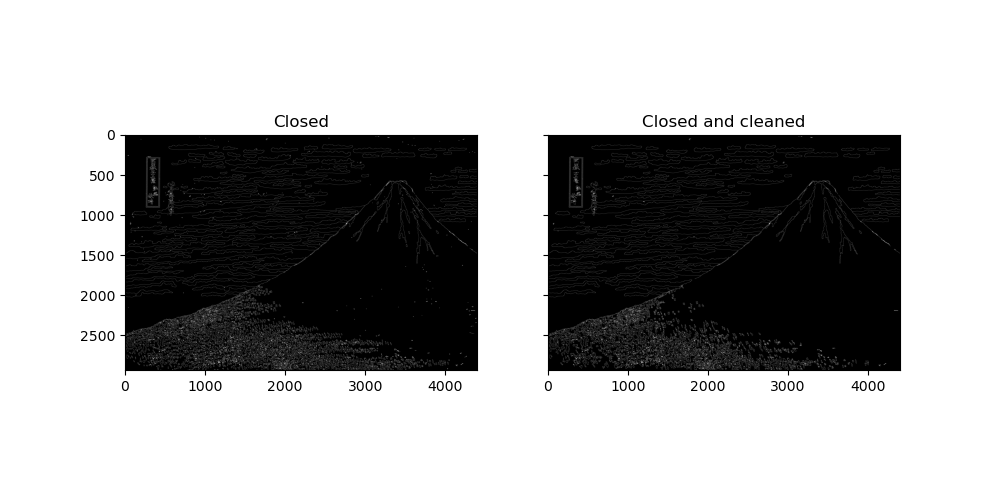

In [119]:
plt.close()
fig, ax = plt.subplots(1,2, figsize = (10,5), sharex = True, sharey = True)
ax[0].set_title("Closed")
ax[0].imshow(edges_closed, cmap = 'gray')
ax[1].set_title("Closed and cleaned")
ax[1].imshow(clean_edges, cmap = 'gray')
plt.show()

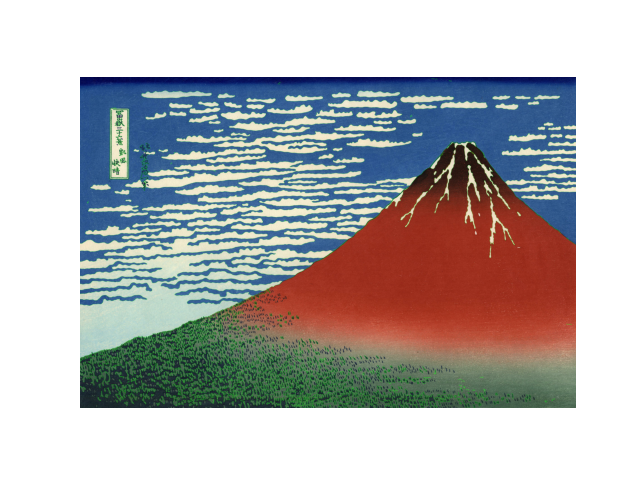

In [123]:
contours, _ = cv2.findContours(clean_edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)

overlay = img.copy()
cv2.drawContours(overlay, contours, -1,  (0,255,0),   1)

plt.close()
plt.imshow(overlay)
plt.axis("off")
plt.show()